In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pysentiment2 as ps
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import gensim
from sklearn.feature_extraction.text import CountVectorizer
import yfinance as yf
from tqdm import tqdm
from tqdm.auto import tqdm
from textblob import TextBlob

def sentiment_vader(var):
    #pip install vaderSentiment
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
    sentiment = SentimentIntensityAnalyzer() 
    out_score = sentiment.polarity_scores(var)
    return out_score
def sentiment_ps(var):
    lm = ps.LM()
    tokens = lm.tokenize(var)
    score = lm.get_score(tokens)
    return score
def sentiment_tb(var):
    text = TextBlob(var)
    return text.sentiment.polarity
def topic_distribution(string_input):
    string_input = [string_input]
    # Fit and transform
    X = vect.transform(string_input)
 
    # Convert sparse matrix to gensim corpus.
    corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)
 
    output = list(ldamodel[corpus])[0]
 
    return output
def topic_prediction(my_document):
    string_input = [my_document]
    X = vect.transform(string_input)
    # Convert sparse matrix to gensim corpus.
    corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)
    output = list(ldamodel[corpus])[0]
    topics = sorted(output,key=lambda x:x[1],reverse=True)
    return topics[0][0]
def normalize(arr):
     return (arr-min(arr))/(max(arr)-min(arr))
def normalize_2(arr):
     return np.interp(arr, (arr.min(), arr.max()), (-1, +1))

In [78]:
# Data Parse and Cleanup
df = pd.read_csv("./doc.csv")
df['Year']= pd.to_datetime(df['Year'])
df.set_index('Year')

,Statement
Year,
1993-02-03,A meeting of the Federal Open Market Committee...
1993-03-23,A meeting of the Federal Open Market Committee...
1993-05-18,A meeting of the Federal Open Market Committee...
1993-07-07,A meeting of the Federal Open Market Committee...
1993-08-17,A meeting of the Federal Open Market Committee...
...,...
2020-07-29,"The Federal Reserve, the central bank of the U..."
2020-09-16,"The Federal Reserve, the central bank of the U..."
2020-11-05,"The Federal Reserve, the central bank of the U..."


In [19]:
analyzer =  SentimentIntensityAnalyzer()
out_score = df['Statement'].progress_apply(sentiment_ps)

100%|██████████| 216/216 [01:18<00:00,  2.76it/s]


In [20]:
positive = []
subjectivity = []
negative = []
polarity = []
for x in tqdm(out_score):
    positive.append(x['Positive'])
    polarity.append(x['Polarity'])
    negative.append(x['Negative'])
    subjectivity.append(x['Subjectivity'])
df['polarity'] = polarity
df['positive'] = positive
df['negative'] = negative
df['subjectivity'] = subjectivity
df.to_pickle("sentiment.pkl")

In [97]:
# If you don't want to reapply sentiment, just load the pickle and start here
df = pd.read_pickle("sentiment.pkl")
df['Year']= pd.to_datetime(df['Year'])
df = df.set_index('Year')
df['Year'] = df.index
df

,Statement,polarity,positive,negative,subjectivity,Year
Year,,,,,,
1993-02-03,A meeting of the Federal Open Market Committee...,-0.134503,74,97,0.080546,1993-02-03
1993-03-23,A meeting of the Federal Open Market Committee...,-0.302857,61,114,0.080571,1993-03-23
1993-05-18,A meeting of the Federal Open Market Committee...,-0.259615,77,131,0.093990,1993-05-18
1993-07-07,A meeting of the Federal Open Market Committee...,-0.156627,35,48,0.038444,1993-07-07
1993-08-17,A meeting of the Federal Open Market Committee...,-0.224299,83,131,0.097717,1993-08-17
...,...,...,...,...,...,...
2020-07-29,"The Federal Reserve, the central bank of the U...",-0.219048,41,64,0.043263,2020-07-29
2020-09-16,"The Federal Reserve, the central bank of the U...",0.064935,82,72,0.062424,2020-09-16
2020-11-05,"The Federal Reserve, the central bank of the U...",-0.349593,40,83,0.049200,2020-11-05


In [117]:
# Get the stock info
price_changes = []
price_change_percentages = []
labels = []
window = 5
# workaround for rolling widow
stock_info = yf.download("SPY", start="1993-02-01", end="2021-02-20")
for index, row in df.iterrows():
    minutes_date = row['Year']
    try:
        start = stock_info.index.get_loc(minutes_date)
    except:
        start = stock_info.index.get_loc(minutes_date + pd.DateOffset(days=1))
    stock_closing_sum = stock_info.iloc[start+window]['Close']
    start_price = stock_info['Close'].iloc[start]
    price_change = start_price - stock_closing_sum
    price_change_percent = (start_price - stock_closing_sum) / start_price
    price_changes.append(price_change)
    price_change_percentages.append(price_change_percent)
    if(price_change > 0):
        labels.append(1)
    else:
        labels.append(0)
df['price_change'] = price_changes
df['price_change_percent'] = price_change_percentages
df['label'] = labels
df = df.join(stock_info)

[*********************100%***********************]  1 of 1 completed


ValueError: columns overlap but no suffix specified: Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [118]:
df

,Statement,polarity,positive,negative,subjectivity,Year,price_change,price_change_percent,label,Open,High,Low,Close,Adj Close,Volume
Year,,,,,,,,,,,,,,,
1993-02-03,A meeting of the Federal Open Market Committee...,-0.134503,74,97,0.080546,1993-02-03,0.093750,0.002092,1,44.406250,44.843750,44.375000,44.812500,26.399649,529400.0
1993-03-23,A meeting of the Federal Open Market Committee...,-0.302857,61,114,0.080571,1993-03-23,-0.343750,-0.007660,0,44.906250,44.937500,44.812500,44.875000,26.561325,55200.0
1993-05-18,A meeting of the Federal Open Market Committee...,-0.259615,77,131,0.093990,1993-05-18,-0.906250,-0.020538,0,44.187500,44.218750,43.968750,44.125000,26.117411,105200.0
1993-07-07,A meeting of the Federal Open Market Committee...,-0.156627,35,48,0.038444,1993-07-07,-0.718750,-0.016209,0,44.187500,44.406250,44.187500,44.343750,26.432894,343700.0
1993-08-17,A meeting of the Federal Open Market Committee...,-0.224299,83,131,0.097717,1993-08-17,-0.687500,-0.015100,0,45.343750,45.531250,45.343750,45.531250,27.140766,369300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-29,"The Federal Reserve, the central bank of the U...",-0.219048,41,64,0.043263,2020-07-29,-6.989990,-0.021500,0,322.119995,325.730011,322.079987,325.119995,321.396606,48454200.0
2020-09-16,"The Federal Reserve, the central bank of the U...",0.064935,82,72,0.062424,2020-09-16,16.179993,0.047754,1,341.510010,343.059998,338.519989,338.820007,334.939697,82096000.0
2020-11-05,"The Federal Reserve, the central bank of the U...",-0.349593,40,83,0.049200,2020-11-05,-2.970001,-0.008480,0,349.239990,352.190002,348.859985,350.239990,347.614868,82039700.0


In [142]:
#Start feature dataset
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
X = clean_dataset(df.drop(['label','Statement','Year','positive','negative','price_change','price_change_percent'],1))
X = np.array(X)
y = np.array(df['label'])


In [143]:
#Split(80% training, 20% test)
import random
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state = random.randint(0,1000))


In [144]:
# Create and train model
model = LinearDiscriminantAnalysis().fit(x_train, y_train)

In [145]:
predictions = model.predict(x_test)

In [146]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.68      0.66      0.67        29
           1       0.33      0.36      0.34        14

    accuracy                           0.56        43
   macro avg       0.51      0.51      0.51        43
weighted avg       0.57      0.56      0.56        43



In [147]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

In [148]:
randomclassifier=RandomForestClassifier(n_estimators=200,criterion='entropy')
m = randomclassifier.fit(x_train,y_train)
predictions_2 = m.predict(x_test)
score = accuracy_score(y_test,predictions)
report = classification_report(y_test,predictions)
print(score)
print(report)

0.5581395348837209
              precision    recall  f1-score   support

           0       0.68      0.66      0.67        29
           1       0.33      0.36      0.34        14

    accuracy                           0.56        43
   macro avg       0.51      0.51      0.51        43
weighted avg       0.57      0.56      0.56        43



In [134]:
statement = "The Federal Reserve is committed to using its full range of tools to support the U.S. economy in this challenging time, thereby promoting its maximum employment and price stability goalsThe COVID-19 pandemic is causing tremendous human and economic hardship across the United States and around the world. Following a moderation in the pace of the recovery, indicators of economic activity and employment have turned up recently, although the sectors most adversely affected by the pandemic remain weak. Inflation continues to run below 2 percent. Overall financial conditions remain accommodative, in part reflecting policy measures to support the economy and the flow of credit to U.S. households and businesses. The path of the economy will depend significantly on the course of the virus, including progress on vaccinations. The ongoing public health crisis continues to weigh on economic activity, employment, and inflation, and poses considerable risks to the economic outlook. The Committee seeks to achieve maximum employment and inflation at the rate of 2 percent over the longer run. With inflation running persistently below this longer-run goal, the Committee will aim to achieve inflation moderately above 2 percent for some time so that inflation averages 2 percent over time and longer‑term inflation expectations remain well anchored at 2 percent. The Committee expects to maintain an accommodative stance of monetary policy until these outcomes are achieved. The Committee decided to keep the target range for the federal funds rate at 0 to 1/4 percent and expects it will be appropriate to maintain this target range until labor market conditions have reached levels consistent with the Committee's assessments of maximum employment and inflation has risen to 2 percent and is on track to moderately exceed 2 percent for some time. In addition, the Federal Reserve will continue to increase its holdings of Treasury securities by at least $80 billion per month and of agency mortgage‑backed securities by at least $40 billion per month until substantial further progress has been made toward the Committee's maximum employment and price stability goals. These asset purchases help foster smooth market functioning and accommodative financial conditions, thereby supporting the flow of credit to households and businesses.In assessing the appropriate stance of monetary policy, the Committee will continue to monitor the implications of incoming information for the economic outlook. The Committee would be prepared to adjust the stance of monetary policy as appropriate if risks emerge that could impede the attainment of the Committee's goals. The Committee's assessments will take into account a wide range of information, including readings on public health, labor market conditions, inflation pressures and inflation expectations, and financial and international developments."

In [127]:
sent = sentiment_ps(statement)
sent

{'Positive': 13,
 'Negative': 9,
 'Polarity': 0.18181817355371938,
 'Subjectivity': 0.09016393405670518}

In [48]:

vect = CountVectorizer(min_df=20, max_df=0.2, stop_words='english', 
                       token_pattern='(?u)\\b\\w\\w\\w+\\b')

In [74]:
df['polarity'] = df['Statement'].apply(sentiment_tb)

<AxesSubplot:label='87cd8647-ac43-4625-90a6-b081374bc302'>

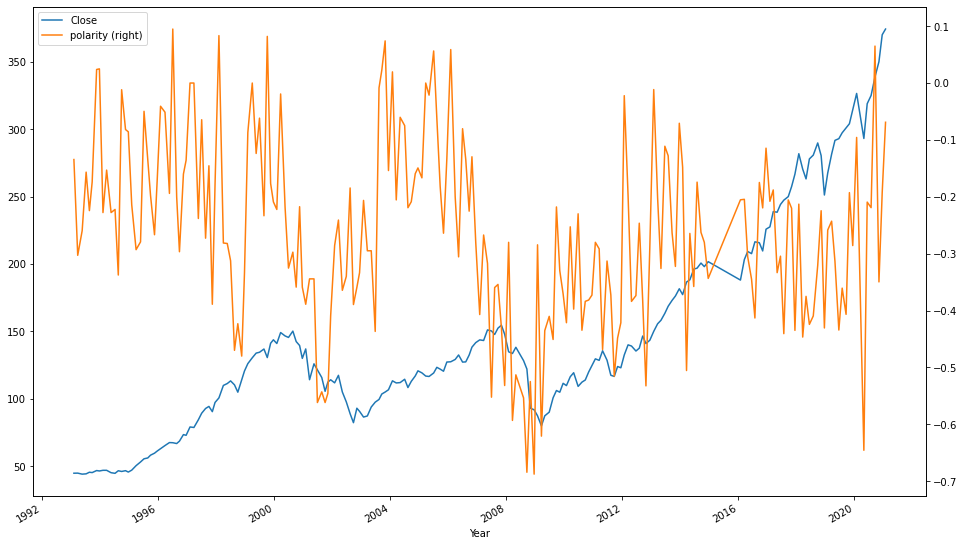

In [151]:
ax = df.plot('Year','Close')
df.plot('Year','polarity',secondary_y=True,ax=ax, figsize=(16, 10))

In [76]:
df

,Statement,polarity,positive,negative,subjectivity,Year,price_change,price_change_percent,label,close
Year,,,,,,,,,,
1993-02-03,A meeting of the Federal Open Market Committee...,0.071700,74,97,0.080546,1993-02-03,0.093750,0.002092,1,44.812500
1993-03-23,A meeting of the Federal Open Market Committee...,0.076863,61,114,0.080571,1993-03-23,-0.343750,-0.007660,0,44.875000
1993-05-18,A meeting of the Federal Open Market Committee...,0.067916,77,131,0.093990,1993-05-18,-0.906250,-0.020538,0,44.125000
1993-07-07,A meeting of the Federal Open Market Committee...,0.045165,35,48,0.038444,1993-07-07,-0.718750,-0.016209,0,44.343750
1993-08-17,A meeting of the Federal Open Market Committee...,0.067590,83,131,0.097717,1993-08-17,-0.687500,-0.015100,0,45.531250
...,...,...,...,...,...,...,...,...,...,...
2020-07-29,"The Federal Reserve, the central bank of the U...",0.034415,41,64,0.043263,2020-07-29,-6.989990,-0.021500,0,325.119995
2020-09-16,"The Federal Reserve, the central bank of the U...",0.110463,82,72,0.062424,2020-09-16,16.179993,0.047754,1,338.820007
2020-11-05,"The Federal Reserve, the central bank of the U...",0.075494,40,83,0.049200,2020-11-05,-2.970001,-0.008480,0,350.239990
